In [83]:
from string import digits
import acquire
import prepare
import requests
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd

import re
import unicodedata
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('figure', figsize=(8, 10))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Notes on Prepare/ Acquire: Create the URL's

- Focused on URL's that were identified as JavaScript or Python
- Opened up searh URL on GitHub, added URLs that fit discription untill 105 were sampled
- Ended on search page 39

## Acquire/Prepare:

In [2]:
urls = acquire.get_urls()
df = acquire.get_readme_articles(urls=urls, cached=True)
df = prepare.clean_data(df)
train, validate, test = prepare.train_validate_test(df)
train.shape, validate.shape, test.shape

((63, 2), (21, 2), (21, 2))

In [3]:
# Lets see what we are playing with
print(train.language.value_counts())
print(validate.language.value_counts())
print(test.language.value_counts())
train.head()

javascript    34
python        29
Name: language, dtype: int64
javascript    12
python         9
Name: language, dtype: int64
javascript    12
python         9
Name: language, dtype: int64


,language,text_filtered
84,javascript,analytics reporter lightweight system publishi...
58,python,note repo going updated anymore tensorflow ver...
19,javascript,angularui companion suite angularjs usage requ...
93,python,deeplift deep learning important feature versi...
101,javascript,reposupervisor reposupervisor tool help detect...


## Explore:


1. What are the most common words in READMEs?
2. What does the distribution of IDFs look like for the most common words?
3. Does the length of the README vary by programming language?
4. Do different programming languages use a different number of unique words?

### Question #1. What are the most common words in READMEs?

In [4]:
# Break it down by language
#train['language'] = train['language'].str.strip()

In [5]:
# Create a corpus of all text
all_words = ' '.join(train.text_filtered)
all_words = re.sub(r'\s.\s', '', all_words)

In [6]:
# Expplore corpus
all_freq = pd.Series(all_words.split()).value_counts()
all_freq.head()

pod      434
file     386
use      267
run      225
video    215
dtype: int64

#### Javascript only

In [7]:
# Break it down by language (Javascript)
mask = train.language == 'javascript'
java_df = train[mask]
# Create a corpus of all text
all_words = ' '.join(java_df.text_filtered)
all_words = re.sub(r'\s.\s', '', all_words)
# Expplore corpus
all_freq = pd.Series(all_words.split()).value_counts()
all_freq.head()

pod          434
file         168
container    136
label        136
node         131
dtype: int64

In [8]:
# Word counts
word_counts = (pd.concat([all_freq], axis=1, sort=True)
               .set_axis(['all'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )
word_counts.sort_values(by='all', ascending=False).head(10)

,all
pod,434
file,168
container,136
label,136
node,131
run,129
kubectl,110
name,110
running,107
kubernetes,105


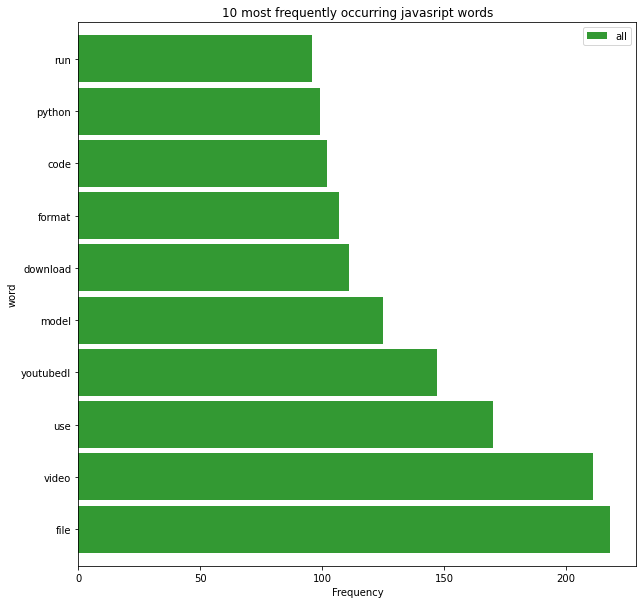

In [13]:
word_counts = word_counts.sort_values(by='all', ascending=False).head(10)
word_counts.plot.barh(color='green', width=.9, figsize=(10, 10), alpha=.8)
plt.title('10 most frequently occurring javasript words')
plt.ylabel('word')
plt.xlabel('Frequency')
plt.show()

****

#### Python Only

In [10]:
# Break it down by language (Python)
mask = train.language == 'python'
python_df = train[mask]
python_df.head()
# Create a corpus of all text
all_words = ' '.join(python_df.text_filtered)
all_words = re.sub(r'\s.\s', '', all_words)
# Expplore corpus
all_freq = pd.Series(all_words.split()).value_counts()
all_freq.head()

file         218
video        211
use          170
youtubedl    147
model        125
dtype: int64

In [11]:
# Word counts
word_counts = (pd.concat([all_freq], axis=1, sort=True)
               .set_axis(['all'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )
word_counts.sort_values(by='all', ascending=False).head(10)

,all
file,218
video,211
use,170
youtubedl,147
model,125
download,111
format,107
code,102
python,99
run,96


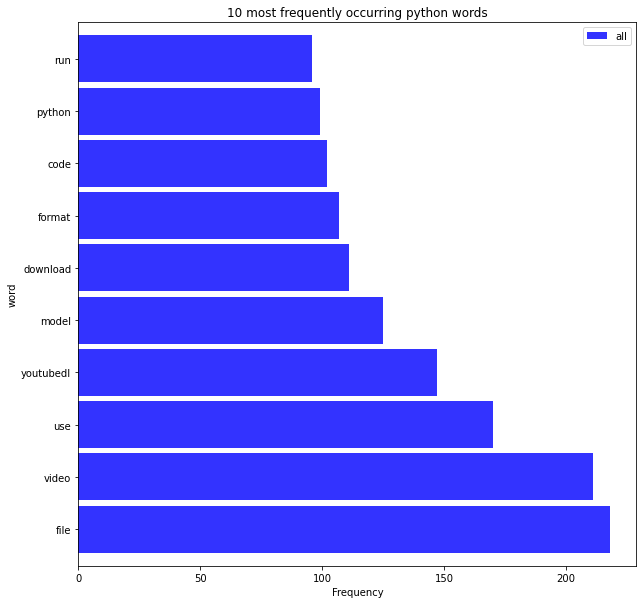

In [12]:
word_counts = word_counts.sort_values(by='all', ascending=False).head(10)
word_counts.plot.barh(color='blue', width=.9, figsize=(10, 10), alpha=.8)
plt.title('10 most frequently occurring python words')
plt.ylabel('word')
plt.xlabel('Frequency')
plt.show()

#### Combined 

In [14]:
# Create Corpus
javascript_words = ' '.join(train[train.language =='javascript'].text_filtered)
python_words = ' '.join(train[train.language =='python'].text_filtered)
all_words = ' '.join(train.text_filtered)
javascript_words = re.sub(r'\s.\s', '', javascript_words)
python_words = re.sub(r'\s.\s', '', python_words)
all_words = re.sub(r'\s.\s', '', all_words)

# Explore corpus
javascript_freq = pd.Series(javascript_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()
word_counts = (pd.concat([all_freq, javascript_freq, python_freq], axis=1, sort=True)
               .set_axis(['all', 'javascript', 'python'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )


# How often to words occur across repos
word_counts.sort_values(by='all', ascending=False).head(10)

,all,javascript,python
pod,434,434,0
file,386,168,218
use,267,97,170
run,225,129,96
video,215,4,211
using,190,98,92
example,177,82,95
name,175,110,65
container,172,136,36
see,159,100,59


In [15]:
# Any words specific only to javascript and never in python?
word_counts[word_counts.python == 0].sort_values(by='javascript', ascending=False).head(10)

,all,javascript,python
pod,434,434,0
kubectl,110,110,0
kubernetes,105,105,0
replicationcontroller,86,86,0
npm,59,59,0
probe,57,57,0
params,51,51,0
listing,45,45,0
ipfs,38,38,0
kubia,37,37,0


In [16]:
# Any words specific only to python and never in javascript?
word_counts[word_counts.javascript == 0].sort_values(by='python', ascending=False).head(10)

,all,javascript,python
youtubedl,147,0,147
model,125,0,125
python,99,0,99
layer,84,0,84
deeplift,52,0,52
score,48,0,48
ipython,41,0,41
lineprofiler,38,0,38
viz,34,0,34
numeric,33,0,33


In [18]:
# These might be words to excude to make modeling easier
word_counts[word_counts.javascript == word_counts.python].sort_values(by='python', ascending=False).head(20)

,all,javascript,python
license,72,36,36
simple,40,20,20
either,40,20,20
google,36,18,18
even,34,17,17
much,26,13,13
field,24,12,12
config,22,11,11
parameter,22,11,11
structure,22,11,11


****
#### Takeaway:

`1. Top 10 Javascript words (file, option, use, npm, using, run, callback, meta, new, install)`   
`2. Top 10 Python words     (file, video, use, youtubed, download, git, formatt, python, run, command)`    
`3. Common words, bad for modeling (file, use, run, using, example)`     
`4. Most common words (Corpus) = Most Common words for specific languages`    

`May remove flie, use, run, using, example from corpus`   

****

### Question #2. What does the distribution of IDFs look like for the most common words?

In [41]:
#Inverse Documnet Frequency; a measure based on in how many documents will a word appear.

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

tfidf_sparse_matrix = tfidf.fit_transform(train.text_filtered)

In [46]:
# Get vocabularies.
tfidf.vocabulary_

{'ha': 14,
 'github': 13,
 'repo': 27,
 'use': 36,
 'open': 24,
 'issue': 16,
 'request': 29,
 'note': 22,
 'version': 38,
 'want': 39,
 'command': 5,
 'source': 32,
 'new': 21,
 'feature': 10,
 'add': 0,
 'code': 4,
 'different': 7,
 'following': 12,
 'python': 26,
 'run': 30,
 'install': 15,
 'make': 19,
 'support': 33,
 'build': 1,
 'project': 25,
 'usage': 35,
 'example': 9,
 'license': 17,
 'file': 11,
 'repository': 28,
 'check': 3,
 'update': 34,
 'change': 2,
 'need': 20,
 'create': 6,
 'way': 40,
 'like': 18,
 'using': 37,
 'npm': 23,
 'directory': 8,
 'work': 41,
 'set': 31}

***
#### Takeaway:
`1. Many of the words are overlap are found in many documents, further evidence that they should be removed befor modeling`

***

### Question #3. Does the length of the README vary by programming language?

In [52]:
# Count lenght of readme text
train['doc_length'] = [len(wordlist) for wordlist in train.text_filtered]
train.head()

,language,text_filtered,doc_length
43,python,edvr ha merged basicsr github repo mirror basi...,2352
70,python,visual studio documentation welcome repo conta...,823
64,python,viz index viz gallery viz interactive website ...,5396
61,javascript,headset attention headset longer us shared you...,1952
20,python,urwid urwid console user interface library pyt...,2332


In [53]:
# Create df
mask = train['language'] == 'python'
python_train = train[mask]
mask = train['language'] == 'javascript'
javascript_train = train[mask]

In [79]:
#Ave doc_lenth(python)
pmean= (python_train.doc_length).mean()
pmean

4075.6071428571427

In [80]:
#Ave doc_lenth(javascript)
jmean=(javascript_train.doc_length).mean()
jmean

2313.657142857143

#### Hypothesis Test (2 Sample T-Test)

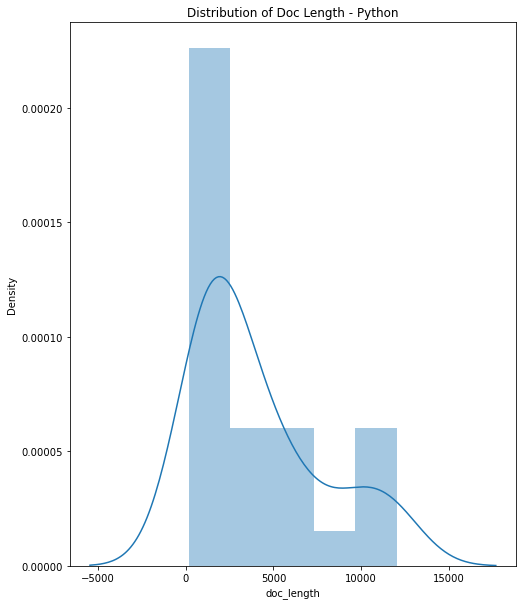

In [72]:
# T-tests assume that the continous variable is normally distributed,
# so we need to do a quick check of this.

sns.distplot(python_train.doc_length)
plt.title('Distribution of Doc Length - Python')
plt.show()

In [73]:
python_train.describe()

,doc_length
count,28.000000
mean,4075.607143
std,3655.024693
min,182.000000
25%,1566.000000
50%,2342.000000
75%,5561.000000
max,12033.000000


***

`Python Data is NOT evenly distributed`

***

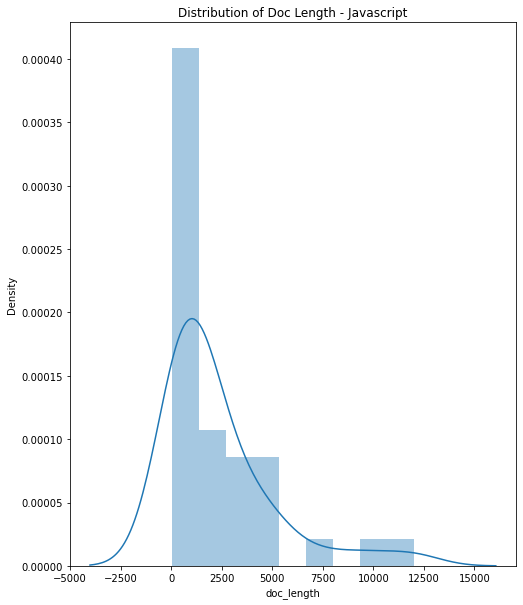

In [74]:
# T-tests assume that the continous variable is normally distributed,
# so we need to do a quick check of this.

sns.distplot(javascript_train.doc_length)
plt.title('Distribution of Doc Length - Javascript')
plt.show()

In [75]:
javascript_train.describe()

,doc_length
count,35.000000
mean,2313.657143
std,2752.311370
min,42.000000
25%,587.500000
50%,1184.000000
75%,2821.000000
max,12001.000000


***

`Javascript Data is NOT evenly distributed`

***

In [88]:
# Variance (2 Sample T-Test)
print(python_train.doc_length.var())
print(javascript_train.doc_length.var())

13359205.506613757
7575217.878991598


***
`Variance is not equal, need to set in function call`
***

#### Null and Alternate

In [92]:
null = "there is not a statisically significant difference between between the length of python repo README.md and javascript repo README.md"
alternate = "there is a statisically significant difference between between the length of python repo README.md and javascript repo README.md"

In [93]:
# I want a 95% confidence interval
alpha = 0.05

#### T-Test

In [99]:

t, p = stats.ttest_ind(python_train.doc_length , javascript_train.doc_length, equal_var =False)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')
print("is p < alpha? ", p < alpha)
print("is t > 0? ", t > 0)
if p > alpha:
    print(f"We fail to reject that {null}")
elif t < 0:
    print(f"We fail to reject that {null}")
else:
    print(f"WE REJECT that {null}")


t = 2.116
p = 0.039
is p < alpha?  True
is t > 0?  True
WE REJECT that there is not a statisically significant difference between between the length of python repo README.md and javascript repo README.md


***

### Question #4. Do different programming languages use a different number of unique words?